In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torch.nn.utils import clip_grad_norm_
from torchvision import transforms, utils, models
from PIL import Image
import os
import math
import numpy as np
import torchbnn as bnn
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score
from itertools import repeat
import pickle

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ",device)

Device:  cuda


In [3]:
batch_size=2
accum_steps=8
lr = 1e-5
epochs=100

# Dataset-- Vindr CC+MLO

In [4]:
class VindrDataset(Dataset):
    def __init__(self, root, split, transform=None):
        self.img_paths=[]
        self.labels=[]
        self.base_path=list(map(os.path.join,root,repeat(split,len(root))))
        print(self.base_path)
        self.transform=transform
        for base in self.base_path:
            if os.path.isdir(base):
                for label in os.listdir(base):
                    label_path=os.path.join(base,label)
                    for img in os.listdir(label_path):
                        if img.endswith((".jpg", ".png", ".gif")):
                            self.img_paths.append(os.path.join(label_path,img))
                            self.labels.append(int(label))
                    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,index):
        img_path=self.img_paths[index]
        label=int(self.labels[index])
        
        #img=Image.open(img_path).convert('L')
        img = cv2.imread(img_path) # read image by cv2
        #print(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img=self.transform(image=img)['image']
            #img=self.transform(img)
            
        #label=torch.tensor(label, dtype=torch.float32)
        
        return img, label

In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transforms=A.Compose([
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.Resize(1024,512),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    A.RandomGamma(gamma_limit=(90, 110), p=0.5),
    #A.Normalize(mean=(0.1744,0.1744, 0.1744), std=(0.2026, 0.2026, 0.2026)),
    #A.Normalize(mean=(0.17463994, 0.17463994, 0.17463994), std=(0.19655961, 0.19655961, 0.19655961)),
    A.Normalize(mean=(0.17635095, 0.17635095, 0.17635095), std=(0.19929671, 0.19929671, 0.19929671)),
    ToTensorV2()
])

val_transforms =  A.Compose([
    A.Resize(1024, 512),
    #A.Normalize(mean=(0.1744,0.1744, 0.1744), std=(0.2026, 0.2026, 0.2026)),
    #A.Normalize(mean=(0.17463994, 0.17463994, 0.17463994), std=(0.19655961, 0.19655961, 0.19655961)),
    A.Normalize(mean=(0.17635095, 0.17635095, 0.17635095), std=(0.19929671, 0.19929671, 0.19929671)),
    ToTensorV2()
])

In [6]:
#root=['../CC', '../MLO']
root=['../CC']

train_dataset=VindrDataset(root, 'train', train_transforms)
test_calib_dataset=VindrDataset(root, 'test', val_transforms)
total_len=len(test_calib_dataset)
calib_ratio=0.4
#print([int(calib_ratio*total_len), int(test_ratio*total_len)],total_len)
calib_len=int(calib_ratio*total_len)
test_len=total_len-calib_len
test_dataset, calib_dataset=random_split(test_calib_dataset, [test_len,calib_len])

nrml_inds, abnrml_inds=[],[]

for i,(_,label) in enumerate(train_dataset):
    if label==0:
        nrml_inds.append(i)
    if label==1:
        abnrml_inds.append(i)
abnrml_length=len(abnrml_inds)
print(f"Abnormal samples={abnrml_length}")
nrml_subset=np.random.choice(nrml_inds,abnrml_length,replace=False)
balanced_inds=list(nrml_subset)+abnrml_inds
balanced_train_dataset=Subset(train_dataset,balanced_inds)
print(f"Original train dataset length={len(train_dataset)} After balancing={len(balanced_train_dataset)}")

train_loader=DataLoader(balanced_train_dataset, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
calib_loader=DataLoader(calib_dataset, batch_size=batch_size, shuffle=True)

['../CC/train']
['../CC/test']
Abnormal samples=751
Original train dataset length=7985 After balancing=1502


## Parameters

In [7]:
#classes, train_count, test_count, calib_count= [0, 1], [14466, 1467], [223, 2168], [1448, 146]
#class_weights=torch.tensor([0.0921, 0.9079]).to(device)

# Model

In [8]:

class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features, prior_mu=0, prior_sigma=0.01):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Learnable parameters: μ and log(σ)
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).normal_(0, 0.01))
        self.weight_log_sigma = nn.Parameter(torch.Tensor(out_features, in_features).fill_(-3))

        self.bias_mu = nn.Parameter(torch.Tensor(out_features).normal_(0, 0.01))
        self.bias_log_sigma = nn.Parameter(torch.Tensor(out_features).fill_(-3))

        self.prior_mu = prior_mu
        self.prior_sigma = prior_sigma
        
        self.KL=0.0

    def forward(self, x):
        weight_log_sigma_clamped = torch.clamp(self.weight_log_sigma, min=-5.0, max=1.0)
        weight_sigma = torch.exp(weight_log_sigma_clamped)
        bias_log_sigma_clamped = torch.clamp(self.bias_log_sigma, min=-5.0, max=1.0)
        bias_sigma = torch.exp(bias_log_sigma_clamped)

        weight = self.weight_mu + weight_sigma * torch.randn_like(self.weight_mu)
        bias = self.bias_mu + bias_sigma * torch.randn_like(self.bias_mu)
        
        self.KL=self.kl_loss()

        return F.linear(x, weight, bias)

    def kl_loss(self):
        weight_kl = self._kl_div(self.weight_mu, self.weight_log_sigma)
        bias_kl = self._kl_div(self.bias_mu, self.bias_log_sigma)
        return weight_kl + bias_kl

    def _kl_div(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        return torch.sum(
            log_sigma - torch.log(torch.tensor(self.prior_sigma)) +
            (self.prior_sigma**2 + (mu - self.prior_mu)**2) / (2 * sigma**2) - 0.5
        )


class BayesianConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1, prior_mu=0, prior_sigma=0.01):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.weight_mu = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)
                                      .normal_(0, 0.01))
        self.weight_log_sigma = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)
                                             .fill_(-3))

        self.bias_mu = nn.Parameter(torch.Tensor(out_channels).normal_(0, 0.01))
        self.bias_log_sigma = nn.Parameter(torch.Tensor(out_channels).fill_(-3))

        self.prior_mu = prior_mu
        self.prior_sigma = prior_sigma
        
        self.KL=0.0

    def forward(self, x):
        weight_log_sigma_clamped = torch.clamp(self.weight_log_sigma, min=-5.0, max=1.0)
        weight_sigma = torch.exp(weight_log_sigma_clamped)
        bias_log_sigma_clamped = torch.clamp(self.bias_log_sigma, min=-5.0, max=1.0)
        bias_sigma = torch.exp(bias_log_sigma_clamped)

        weight = self.weight_mu + weight_sigma * torch.randn_like(self.weight_mu)
        bias = self.bias_mu + bias_sigma * torch.randn_like(self.bias_mu)
        
        self.KL=self.kl_loss()

        return F.conv2d(x, weight, bias, stride=self.stride, padding=self.padding)

    def kl_loss(self):
        weight_kl = self._kl_div(self.weight_mu, self.weight_log_sigma)
        bias_kl = self._kl_div(self.bias_mu, self.bias_log_sigma)
        return weight_kl + bias_kl

    def _kl_div(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        return torch.sum(
            log_sigma - torch.log(torch.tensor(self.prior_sigma)) +
            (self.prior_sigma**2 + (mu - self.prior_mu)**2) / (2 * sigma**2) - 0.5
        )


In [9]:
class ConfigurableBNN(nn.Module):
    def __init__(
        self,
        cfg,
        in_channels,
        num_classes=1,
        prior_mu=0,
        prior_sigma=0.1,
        kernel_size=3,
        padding=1
    ):
        super(ConfigurableBNN, self).__init__()

        self.features = self._make_layers(cfg, in_channels, prior_mu, prior_sigma, kernel_size, padding)
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            BayesianLinear(in_features=512, out_features=4096, prior_mu=prior_mu, prior_sigma=prior_sigma),
            nn.ReLU(True),
            nn.Dropout(),
            BayesianLinear(in_features=4096, out_features=4096, prior_mu=prior_mu, prior_sigma=prior_sigma),
            nn.ReLU(True),
            nn.Dropout()
        )
        self.logits = bnn.BayesLinear(in_features=4096, out_features=num_classes, prior_mu=prior_mu, prior_sigma=prior_sigma)
        self.log_var = bnn.BayesLinear(in_features=4096, out_features=num_classes, prior_mu=prior_mu, prior_sigma=prior_sigma)

    def _make_layers(self, cfg, in_channels, prior_mu, prior_sigma, kernel_size, padding):
        layers = []
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [
                    BayesianConv2d(in_channels=in_channels, out_channels=v, kernel_size=kernel_size, padding=padding, prior_mu=prior_mu, prior_sigma=prior_sigma),
                    nn.BatchNorm2d(v),
                    nn.ReLU(inplace=True)
                ]
                in_channels = v
        layers += [nn.AdaptiveAvgPool2d((1, 1))]
        return nn.Sequential(*layers)

    def forward(self, x):
        kl = 0.0
        for layer in self.features:
            x = layer(x)
            if hasattr(layer, 'KL'):
                kl += layer.KL

        x = self.flatten(x)

        for layer in self.fc_layers:
            x = layer(x)
            if hasattr(layer, 'KL'):
                kl += layer.KL
        

        return self.logits(x), self.log_var(x), kl




In [10]:

vgg19_cfg = [64, 64, 'M',
             128, 128, 'M',
             256, 256, 256, 256, 'M',
             512, 512, 512, 512, 'M',
             512, 512, 512, 512, 'M']

model=ConfigurableBNN(vgg19_cfg, in_channels=3).to(device)
summary(model, input_size=(3,1024,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
    BayesianConv2d-1        [-1, 64, 1024, 512]               0
       BatchNorm2d-2        [-1, 64, 1024, 512]             128
              ReLU-3        [-1, 64, 1024, 512]               0
    BayesianConv2d-4        [-1, 64, 1024, 512]               0
       BatchNorm2d-5        [-1, 64, 1024, 512]             128
              ReLU-6        [-1, 64, 1024, 512]               0
         MaxPool2d-7         [-1, 64, 512, 256]               0
    BayesianConv2d-8        [-1, 128, 512, 256]               0
       BatchNorm2d-9        [-1, 128, 512, 256]             256
             ReLU-10        [-1, 128, 512, 256]               0
   BayesianConv2d-11        [-1, 128, 512, 256]               0
      BatchNorm2d-12        [-1, 128, 512, 256]             256
             ReLU-13        [-1, 128, 512, 256]               0
        MaxPool2d-14        [-1, 128, 2

# Early Stopping

In [33]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0.0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last improvement.
            verbose (bool): If True, prints improvement messages.
            delta (float): Minimum change to qualify as improvement.
            path (str): Where to save the best model.
            trace_func (function): Logging function (default is print).
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, checkpoint):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, checkpoint)

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.save_checkpoint(val_loss, checkpoint)
            self.counter = 0

    def save_checkpoint(self, val_loss, checkpoint):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            self.trace_func(f"Validation loss decreased ({self.val_min:.6f} --> {val_loss:.6f}).  Saving model ...")
        torch.save(checkpoint, self.path)
        self.val_min = val_loss


# Loss Function, Training

In [34]:
import torch
import torch.nn as nn

def bnn_loss(logits, log_var, labels, kl_loss, class_weights=None, beta=1.0, min_var=1e-3, max_var=1e+3):
    """
    Combines aleatoric and epistemic (KL) uncertainty for binary classification loss.

    Parameters:
    - logits: Raw output from model before sigmoid
    - log_var: Predicted log variance from model
    - labels: Ground truth labels (0 or 1)
    - kl_loss: Sum of KL divergence from all Bayesian layers
    - class_weights: Tensor of shape [num_classes], e.g., [0.3, 0.7] for class 0 and 1
    - beta: Weight for KL term (typically 1 / N, or schedule during training)
    """
    labels = labels.float().unsqueeze(1)  # (B, 1)
    logits = logits.unsqueeze(1) if logits.dim() == 1 else logits
    log_var = log_var.unsqueeze(1) if log_var.dim() == 1 else log_var

    bce_loss = nn.BCEWithLogitsLoss(reduction='none')(logits, labels)
    #print(f"logits={logits}, labels={labels}, bce loss={bce_loss}")

    # Apply class weights
    if class_weights is not None:
        weights = class_weights[labels.long().squeeze()]
        #print(f"class weights={weights}")
        bce_loss = bce_loss.view(-1) * weights

    # Aleatoric uncertainty
    log_var = torch.clamp(log_var, min=-10.0, max=10.0)
    aleatoric_uncertainty = torch.exp(log_var)
    aleatoric_uncertainty = torch.clamp(aleatoric_uncertainty, min=min_var, max=max_var)

    # Uncertainty-aware loss
    uncertainty_loss = bce_loss / (2 * aleatoric_uncertainty) + 0.5 * log_var

    # Total loss = Aleatoric + KL
    total_loss = uncertainty_loss.mean() + beta * kl_loss

    return total_loss, aleatoric_uncertainty.mean(), kl_loss


In [35]:
#sigmoid-based annealing
def get_beta_sigmoid(epoch, start_epoch):
    return float(1 / (1 + np.exp(- (epoch - start_epoch - 25) / 10)))  # Smooth ramp

# linear annealing over 100 epochs
def get_beta_linear(epoch, start_epoch, total_epoch=100):
    return min(1.0, (epoch - start_epoch) / total_epoch)

# Training function
def train_model(model, train_loader, optimizer, device, epoch, start_epoch, total_epoch=100, class_weights=None):
    train_losses, train_metrics,  = [], []

    model.train()
    train_preds, train_targets = [], []
    epoch_loss = 0
    eopch_aleatoric = 0
    epoch_epistemic = 0
    #beta = linear_beta_schedule(epoch, epochs)
    beta=get_beta_sigmoid(epoch, start_epoch)

    for i,(images, labels) in enumerate(tqdm(train_loader, desc="Train")):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits, log_var, kl = model(images)
        #print(f"Logits={logits} log var={log_var} KL Loss={kl}")
        logits = torch.clamp(logits, min=-30.0, max=30.0)
        #print("logits max:", logits.max().item(), "min:", logits.min().item())
        loss, aleatoric, epstemic = bnn_loss(logits, log_var, labels, kl, class_weights, beta)
        #print(f"total loss={loss}, aleatoric uncertainty={aleatoric}, epistemic uncertainty={epstemic}")

        loss = loss / accum_steps
        loss.backward()
        if (i + 1) % accum_steps == 0 or (i + 1) == len(train_loader):
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss += loss.item()
        eopch_aleatoric += aleatoric.item()
        epoch_epistemic += epstemic.item()
        train_preds.extend((torch.sigmoid(logits) > 0.5).cpu().numpy())
        train_targets.extend(labels.cpu().numpy())
        
#         if i==accum_steps:
#             break

    acc = accuracy_score(train_targets, train_preds)
    prec = precision_score(train_targets, train_preds)
    rec = recall_score(train_targets, train_preds)

    N=len(train_loader)
    train_losses.append((epoch_loss /N , eopch_aleatoric/N, epoch_epistemic/N))
    train_metrics.append((acc, prec, rec))

    return train_losses, train_metrics

In [36]:
def validate(model, loader, split, device, th=0.5, T=10):
    # Validation loop
    model.eval()
    val_losses, val_metrics = [], []
    val_preds, val_targets = [], []
    val_epoch_loss = []
    val_eopch_aleatoric = []
    val_epoch_epistemic  = []
    logits_lst, log_var_lst, kl_lst, var_logits_lst, entropy_lst=[], [], [], [], []

    with torch.no_grad():
        for images, labels in tqdm(loader):
            images, labels = images.to(device), labels.to(device)
            
            logits_T, log_var_T, kl_T = [], [], []
            
            for _ in range(T):
                logits, log_var, kl = model(images)
                logits_T.append(logits)
                log_var_T.append(log_var)
                kl_T.append(kl)
                
            #print(f"VAL Logits={logits} log var={log_var} KL Loss={kl}")
            logits_T = torch.stack(logits_T)        
            log_var_T = torch.stack(log_var_T)
            kl_T = torch.stack(kl_T)
            
            mean_logits = logits_T.mean(0)           
            var_logits = logits_T.var(0)             

            # Predictive entropy calculation
            prob_T = torch.sigmoid(logits_T)         
            mean_prob = prob_T.mean(0)              
            entropy = - (mean_prob * torch.log(mean_prob + 1e-8) + 
                         (1 - mean_prob) * torch.log(1 - mean_prob + 1e-8))
            
            mean_log_var = log_var_T.mean(0)
            mean_kl = kl_T.mean(0)
            
            logits_lst.append(mean_logits.cpu().numpy())
            log_var_lst.append(mean_log_var.cpu().numpy())
            kl_lst.append(mean_kl.cpu())
            var_logits_lst.append(var_logits.cpu().numpy())
            entropy_lst.append(entropy.cpu().numpy())
            
            loss, aleatoric, epstemic= bnn_loss(mean_logits, mean_log_var, labels, mean_kl)
            val_epoch_loss.append(loss.item())
            val_eopch_aleatoric.append(aleatoric.item())
            val_epoch_epistemic.append(epstemic.item())
            
            val_preds.extend((torch.sigmoid(mean_logits) > th).cpu().numpy())
            val_targets.extend(labels.cpu().numpy())
            
            

    acc = accuracy_score(val_targets, val_preds)
    prec = precision_score(val_targets, val_preds)
    rec = recall_score(val_targets, val_preds)

    N=len(loader)
    val_losses.extend((sum(val_epoch_loss) /N,  sum(val_eopch_aleatoric)/N, sum(val_epoch_epistemic)/N))
    val_metrics.extend((acc, prec, rec))
    
    # Combine into a dictionary
    history = {
        "logits": logits_lst,
        "log_var": log_var_lst,
        "kl":kl_lst,
        "var":var_logits_lst,
        "entropy":entropy_lst,
        "total_loss": val_epoch_loss,
        "aleatoric_loss":val_eopch_aleatoric,
        "epistemic_loss":val_epoch_epistemic,
        "avg_losses":val_losses,
        "avg_metrics":val_metrics
    }

    # Save to a single pickle file
    with open(split+"_history.pkl", "wb") as f:
        pickle.dump(history, f)

    return val_losses, val_metrics


In [37]:
optimizer = optim.Adam(model.parameters(), lr=lr)

In [38]:
def training(model, optimizer, start_epoch=0, checkpoint=None): 
    #training
    torch.autograd.set_detect_anomaly(True)


    early_stopping = EarlyStopping(patience=7, verbose=True, path='best_mybnn_model.pt')
    
    if checkpoint is not None:
        all_wt_mu, all_wt_sigma, all_bias_mu, all_bias_sigma=checkpoint['wt_mu'], checkpoint['wt_sigma'], checkpoint['bias_mu'], checkpoint['bias_sigma']
        losses, metrics=checkpoint['loss'], checkpoint['metrics']
    
    else:
        all_wt_mu, all_wt_sigma, all_bias_mu, all_bias_sigma=[],[],[],[]
        losses, metrics=[],[]

    #for epoch in range(1):
    for epoch in range(start_epoch,start_epoch+101):
        train_loss, train_metrics = train_model(model, train_loader, optimizer, device, epoch, start_epoch)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss}, Metrics={train_metrics}")
              #,Accuracy:{train_metrics[0]}, Precision:{train_metrics[1]}, recall: {train_metrics[2]}")

        losses.extend(train_loss)
        metrics.extend(train_metrics)
        # After each epoch, track mu and sigma

        weight_mu_values = []
        weight_sigma_values = []
        bias_mu_values = []
        bias_sigma_values = []

        for name, module in model.named_modules():
            if hasattr(module, 'weight_mu') and hasattr(module, 'weight_log_sigma'):
                weight_mu_values.append(module.weight_mu.detach().cpu().flatten())
                sigma = torch.exp(module.weight_log_sigma).detach().cpu().flatten()
                weight_sigma_values.append(sigma)
            if hasattr(module, 'bias_mu') and hasattr(module, 'bias_log_sigma'):
                bias_mu_values.append(module.bias_mu.detach().cpu().flatten())
                sigma = torch.exp(module.bias_log_sigma).detach().cpu().flatten()
                bias_sigma_values.append(sigma)

        all_wt_mu.extend([torch.cat(weight_mu_values).mean().item()])
        all_wt_sigma.extend([torch.cat(weight_sigma_values).mean().item()])
        all_bias_mu.extend([torch.cat(bias_mu_values).mean().item()])
        all_bias_sigma.extend([torch.cat(bias_sigma_values).mean().item()])

        #if (epoch+1)%5 == 0:
        checkpoint={'epoch': epoch,
                   'model_state_dict': model.state_dict(),
                   'optimizer_state_dict': optimizer.state_dict(),
                   'loss':losses,
                   'metrics': metrics,
                   'wt_mu' :all_wt_mu,
                   'wt_sigma': all_wt_sigma,
                   'bias_mu': all_bias_mu,
                   'bias_sigma': all_bias_sigma}
        #torch.save(checkpoint, 'checkpoint_'+epoch+'.pth')

        test_losses, test_metrics = validate(model, test_loader, 'test', device, th=0.5)

        early_stopping(test_losses[0], checkpoint)

        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    checkpoint={'epoch': epoch,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss':losses,
               'metrics': metrics,
               'wt_mu' :all_wt_mu,
               'wt_sigma': all_wt_sigma,
               'bias_mu': all_bias_mu,
               'bias_sigma': all_bias_sigma}
    torch.save(checkpoint, "custom_bnn_vindr_final.pth")

In [39]:
best_checkpoint=torch.load('best_mybnn_model.pt')
print(f"best model epoch={best_checkpoint['epoch']} loss={best_checkpoint['loss'][-1]} metrics={best_checkpoint['metrics'][-1]}")

model.load_state_dict(best_checkpoint['model_state_dict'])
optimizer.load_state_dict(best_checkpoint['optimizer_state_dict'])
start_epoch = best_checkpoint['epoch']

training(model, optimizer, start_epoch, best_checkpoint)

# final_checkpoint=torch.load('custom_bnn_vindr_final.pth')
# print(f"final model epoch={final_checkpoint['epoch']} loss={final_checkpoint['loss'][-1]} metrics={final_checkpoint['metrics'][-1]}")
# best_model=final_checkpoint['model_state_dict']

best model epoch=63 loss=(2037479.111517976, 758.2251150266854, 25872198.055925433) metrics=(0.5093209054593875, 0.5094086021505376, 0.5046604527296937)


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 64/100, Loss: [(244587.85034537283, 768.4208233429484, 25789860.450066578)], Metrics=[(0.5026631158455392, 0.5025380710659898, 0.5272969374167776)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (inf --> 25747755.996661).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 65/100, Loss: [(267254.68962217047, 746.8333320480856, 25702127.73635153)], Metrics=[(0.5006657789613849, 0.5007032348804501, 0.474034620505992)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (25747755.996661 --> 25655564.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 66/100, Loss: [(291798.0042859521, 740.8153220571501, 25614092.40479361)], Metrics=[(0.5166444740346205, 0.5159642401021711, 0.5379494007989347)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (25655564.000000 --> 25572587.993322).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 67/100, Loss: [(318383.0102779627, 756.1792102029599, 25531099.467376832)], Metrics=[(0.4966711051930759, 0.4966442953020134, 0.49267643142476697)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (25572587.993322 --> 25487573.472454).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 68/100, Loss: [(347043.2648551931, 759.9402145143042, 25444990.14114514)], Metrics=[(0.5, 0.5, 0.49267643142476697)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (25487573.472454 --> 25402053.505843).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 69/100, Loss: [(377891.41840046603, 747.222258274715, 25358246.681757655)], Metrics=[(0.5053262316910786, 0.5054495912806539, 0.4940079893475366)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (25402053.505843 --> 25312753.459098).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 70/100, Loss: [(410989.7858688416, 750.057616859025, 25268282.46604527)], Metrics=[(0.5099866844207723, 0.5102599179206566, 0.4966711051930759)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (25312753.459098 --> 25221481.445743).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 71/100, Loss: [(446468.31462217047, 754.7148458743635, 25176910.221038613)], Metrics=[(0.4960053262316911, 0.4959893048128342, 0.4940079893475366)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (25221481.445743 --> 25131152.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 72/100, Loss: [(484392.28174933424, 736.8338930330408, 25085060.95339547)], Metrics=[(0.5133155792276964, 0.5144508670520231, 0.474034620505992)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (25131152.000000 --> 25038604.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 73/100, Loss: [(524946.3201564581, 739.265966006478, 24997912.04260985)], Metrics=[(0.5326231691078562, 0.5338865836791148, 0.5139813581890812)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (25038604.000000 --> 24957765.392321).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 74/100, Loss: [(568206.9882656458, 756.5794279469324, 24915857.829560585)], Metrics=[(0.4833555259653795, 0.48299319727891155, 0.47270306258322237)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (24957765.392321 --> 24873973.402337).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 75/100, Loss: [(614014.2158788282, 776.1020022516431, 24830233.086551264)], Metrics=[(0.5026631158455392, 0.5027173913043478, 0.49267643142476697)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (24873973.402337 --> 24784804.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 76/100, Loss: [(662298.2321904128, 760.5222436762961, 24738149.4114514)], Metrics=[(0.5146471371504661, 0.5152777777777777, 0.4940079893475366)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (24784804.000000 --> 24692829.405676).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 77/100, Loss: [(713332.2382656458, 791.0642917373648, 24652143.03062583)], Metrics=[(0.4780292942743009, 0.4778523489932886, 0.474034620505992)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (24692829.405676 --> 24606029.459098).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 78/100, Loss: [(766792.2971038615, 787.0293690546071, 24561910.561917443)], Metrics=[(0.4973368841544607, 0.49727520435967304, 0.48601864181091875)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (24606029.459098 --> 24518761.395659).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 79/100, Loss: [(822898.3773302264, 802.7279312498935, 24476778.090545937)], Metrics=[(0.481358189081225, 0.48148148148148145, 0.48468708388814913)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (24518761.395659 --> 24433020.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 80/100, Loss: [(881332.1793442077, 792.3722387200986, 24391394.55126498)], Metrics=[(0.4840213049267643, 0.48404255319148937, 0.48468708388814913)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (24433020.000000 --> 24350241.485810).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 81/100, Loss: [(941995.6745173102, 783.6411875150288, 24306558.657789614)], Metrics=[(0.49201065246338216, 0.49175824175824173, 0.4766977363515313)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (24350241.485810 --> 24259468.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 82/100, Loss: [(1004408.5415279627, 795.4204125830115, 24215166.857523303)], Metrics=[(0.46870838881491345, 0.46936114732724904, 0.4793608521970706)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (24259468.000000 --> 24169565.402337).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 83/100, Loss: [(1068719.6418109187, 796.3174210852704, 24127554.090545937)], Metrics=[(0.4993342210386152, 0.49929676511954996, 0.47270306258322237)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (24169565.402337 --> 24081324.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 84/100, Loss: [(1134349.6341544606, 811.3075264249331, 24036001.379494008)], Metrics=[(0.5093209054593875, 0.5093085106382979, 0.5099866844207723)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (24081324.000000 --> 23990588.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 85/100, Loss: [(1201259.101864181, 802.5262149347891, 23945896.950732358)], Metrics=[(0.5079893475366178, 0.5080213903743316, 0.5059920106524634)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (23990588.000000 --> 23899601.455760).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 86/100, Loss: [(1269028.5267976031, 793.1579088287065, 23855674.96671105)], Metrics=[(0.5059920106524634, 0.5059132720105125, 0.5126498002663116)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (23899601.455760 --> 23808981.439065).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 87/100, Loss: [(1337354.1163448736, 799.5236695422492, 23765784.91611185)], Metrics=[(0.4806924101198402, 0.47994467496542187, 0.4620505992010652)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (23808981.439065 --> 23723612.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 88/100, Loss: [(1406091.742343542, 806.0236954424025, 23679937.992010653)], Metrics=[(0.5226364846870839, 0.5234806629834254, 0.5046604527296937)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (23723612.000000 --> 23634805.365609).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 89/100, Loss: [(1474569.5667443408, 813.0056316144872, 23592604.1011984)], Metrics=[(0.4873501997336884, 0.4864479315263909, 0.4540612516644474)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (23634805.365609 --> 23550988.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 90/100, Loss: [(1542633.4317576564, 804.809226385745, 23507100.83355526)], Metrics=[(0.4806924101198402, 0.47994467496542187, 0.4620505992010652)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (23550988.000000 --> 23462161.348915).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 91/100, Loss: [(1609522.5585885486, 810.8416141717705, 23417828.03728362)], Metrics=[(0.5133155792276964, 0.5136612021857924, 0.5006657789613849)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (23462161.348915 --> 23372189.412354).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 92/100, Loss: [(1675169.585219707, 804.6517496463134, 23328836.753661785)], Metrics=[(0.503994673768309, 0.504, 0.5033288948069241)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (23372189.412354 --> 23283969.325543).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 93/100, Loss: [(1739246.2380159786, 818.9641356560846, 23240294.19973369)], Metrics=[(0.4993342210386152, 0.4993288590604027, 0.49533954727030627)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (23283969.325543 --> 23195765.325543).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 94/100, Loss: [(1801462.7844540612, 821.4642182845735, 23152429.001331557)], Metrics=[(0.5006657789613849, 0.5006622516556292, 0.5033288948069241)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (23195765.325543 --> 23108045.348915).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 95/100, Loss: [(1861609.5937083887, 831.4786814654364, 23065868.191744342)], Metrics=[(0.4866844207723036, 0.4863013698630137, 0.47270306258322237)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (23108045.348915 --> 23021712.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 96/100, Loss: [(1919323.4034620507, 832.8578613269613, 22979131.914780293)], Metrics=[(0.5013315579227696, 0.5014367816091954, 0.4647137150466045)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (23021712.000000 --> 22936017.375626).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 97/100, Loss: [(1974537.9920106526, 819.004946965916, 22893619.17443409)], Metrics=[(0.5053262316910786, 0.5054347826086957, 0.49533954727030627)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (22936017.375626 --> 22850809.352254).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 98/100, Loss: [(2027257.6835885486, 840.3817155791135, 22811418.88415446)], Metrics=[(0.4733688415446072, 0.47093023255813954, 0.43142476697736354)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (22850809.352254 --> 22769197.365609).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 99/100, Loss: [(2076935.259653795, 850.3313036624496, 22727705.222370174)], Metrics=[(0.5013315579227696, 0.5014005602240896, 0.4766977363515313)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (22769197.365609 --> 22683708.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 100/100, Loss: [(2123241.6081890813, 842.7322122832537, 22639746.94274301)], Metrics=[(0.503994673768309, 0.5040760869565217, 0.4940079893475366)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (22683708.000000 --> 22594445.385643).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 101/100, Loss: [(2166950.7296937415, 837.2932661069623, 22556705.16644474)], Metrics=[(0.5079893475366178, 0.5084507042253521, 0.4806924101198402)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (22594445.385643 --> 22516208.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 102/100, Loss: [(2207551.3042609855, 853.9395250550452, 22473245.53928096)], Metrics=[(0.5066577896138482, 0.5071428571428571, 0.47270306258322237)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (22516208.000000 --> 22428444.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 103/100, Loss: [(2244676.022969374, 867.5054160148181, 22385351.946737684)], Metrics=[(0.5199733688415447, 0.5202702702702703, 0.5126498002663116)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (22428444.000000 --> 22341028.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 104/100, Loss: [(2278693.2959387484, 859.3985442695947, 22296907.893475365)], Metrics=[(0.5, 0.5, 0.4580559254327563)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (22341028.000000 --> 22253165.232053).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 105/100, Loss: [(2310226.8438748335, 850.091701186618, 22213020.08255659)], Metrics=[(0.49267643142476697, 0.4922425952045134, 0.4647137150466045)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (22253165.232053 --> 22171241.265442).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 106/100, Loss: [(2338944.946071904, 871.3732928971201, 22129584.138482023)], Metrics=[(0.5059920106524634, 0.5067466266866567, 0.45006657789613846)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (22171241.265442 --> 22086676.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 107/100, Loss: [(2364564.9027962717, 869.2394855317708, 22043191.81890812)], Metrics=[(0.4933422103861518, 0.49266862170087977, 0.4474034620505992)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (22086676.000000 --> 21999177.138564).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 108/100, Loss: [(2387439.987683089, 861.964375339207, 21956014.471371505)], Metrics=[(0.5153129161118508, 0.5172413793103449, 0.459387483355526)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (21999177.138564 --> 21912857.128548).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 109/100, Loss: [(2407983.184753662, 864.6174855158998, 21870801.267643142)], Metrics=[(0.5239680426098535, 0.5257879656160458, 0.48868175765645805)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (21912857.128548 --> 21826461.171953).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 110/100, Loss: [(2426140.444740346, 868.6336315440857, 21785720.838881493)], Metrics=[(0.4986684420772304, 0.4985754985754986, 0.46604527296937415)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (21826461.171953 --> 21744141.195326).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 111/100, Loss: [(2442235.161451398, 864.7596604191156, 21702454.45539281)], Metrics=[(0.4980026631158455, 0.4979020979020979, 0.474034620505992)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (21744141.195326 --> 21660844.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 112/100, Loss: [(2456215.060252996, 873.0550026654857, 21619557.37150466)], Metrics=[(0.4793608521970706, 0.47788873038516405, 0.44607190412782954)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (21660844.000000 --> 21577497.145242).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 113/100, Loss: [(2468260.85885486, 852.0868805645164, 21537147.765645806)], Metrics=[(0.5226364846870839, 0.5232876712328767, 0.5086551264980027)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (21577497.145242 --> 21495260.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 114/100, Loss: [(2478459.440412783, 879.1064122261071, 21455085.6804261)], Metrics=[(0.5126498002663116, 0.5131761442441054, 0.49267643142476697)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (21495260.000000 --> 21414032.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 115/100, Loss: [(2486961.9490679093, 892.9384384714284, 21373266.194407456)], Metrics=[(0.5199733688415447, 0.5208333333333334, 0.4993342210386152)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (21414032.000000 --> 21330948.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 116/100, Loss: [(2493614.9091211716, 889.3736247083144, 21289433.278295606)], Metrics=[(0.4873501997336884, 0.48633093525179855, 0.45006657789613846)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (21330948.000000 --> 21247780.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 117/100, Loss: [(2498943.124500666, 872.6313032436427, 21207082.292942744)], Metrics=[(0.5119840213049268, 0.513235294117647, 0.4647137150466045)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (21247780.000000 --> 21165636.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 118/100, Loss: [(2502919.089214381, 878.0249668636116, 21124941.177097205)], Metrics=[(0.5173102529960053, 0.518361581920904, 0.48868175765645805)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (21165636.000000 --> 21083484.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 119/100, Loss: [(2505570.112183755, 895.0490965399603, 21042338.655126497)], Metrics=[(0.5153129161118508, 0.5173978819969742, 0.45539280958721706)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (21083484.000000 --> 21002336.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 120/100, Loss: [(2507389.844873502, 883.2415705331676, 20962640.31424767)], Metrics=[(0.5153129161118508, 0.5172413793103449, 0.459387483355526)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (21002336.000000 --> 20921685.131886).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 121/100, Loss: [(2507923.9464047938, 890.421877040326, 20881009.94141145)], Metrics=[(0.48934753661784286, 0.4880597014925373, 0.43541944074567246)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (20921685.131886 --> 20840668.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 122/100, Loss: [(2507639.693741678, 887.9992676170468, 20800895.520639148)], Metrics=[(0.5099866844207723, 0.5115562403697997, 0.4420772303595206)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (20840668.000000 --> 20760052.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 123/100, Loss: [(2506421.017976032, 901.3309362238481, 20720421.38482024)], Metrics=[(0.46937416777629826, 0.4666666666666667, 0.42876165113182424)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (20760052.000000 --> 20679149.185309).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 124/100, Loss: [(2504166.4940079893, 898.1858382349776, 20638175.201065246)], Metrics=[(0.48468708388814913, 0.4827586206896552, 0.42876165113182424)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (20679149.185309 --> 20596053.198664).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 125/100, Loss: [(2501291.387816245, 903.7460950754804, 20556949.190412782)], Metrics=[(0.49467376830892146, 0.4938650306748466, 0.42876165113182424)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (20596053.198664 --> 20516073.225376).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 126/100, Loss: [(2497747.7140479363, 903.9755817434356, 20475852.213049266)], Metrics=[(0.49067909454061254, 0.4903047091412742, 0.47137150466045274)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (20516073.225376 --> 20435708.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 127/100, Loss: [(2493675.155126498, 899.3647362071647, 20395571.824234355)], Metrics=[(0.5059920106524634, 0.5062937062937063, 0.48202396804260983)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (20435708.000000 --> 20355017.265442).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 128/100, Loss: [(2489398.148135819, 910.2383328894015, 20318167.456724368)], Metrics=[(0.5066577896138482, 0.5068306010928961, 0.4940079893475366)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (20355017.265442 --> 20279789.318865).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 129/100, Loss: [(2484540.940745672, 905.3147622552696, 20240242.4873502)], Metrics=[(0.5019973368841545, 0.5021520803443329, 0.46604527296937415)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (20279789.318865 --> 20199497.312187).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 130/100, Loss: [(2478870.364846871, 897.0180006687434, 20159445.35286285)], Metrics=[(0.4993342210386152, 0.49926144756277696, 0.45006657789613846)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (20199497.312187 --> 20118745.212020).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 131/100, Loss: [(2472910.13448735, 911.9303586478349, 20079758.913448736)], Metrics=[(0.4960053262316911, 0.4959016393442623, 0.4833555259653795)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (20118745.212020 --> 20041508.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 132/100, Loss: [(2466891.9490679093, 928.0732421155759, 20002844.04260985)], Metrics=[(0.5193075898801598, 0.5201668984700973, 0.4980026631158455)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (20041508.000000 --> 19964116.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 133/100, Loss: [(2460438.1098535284, 910.836491058409, 19925013.53395473)], Metrics=[(0.5079893475366178, 0.5084745762711864, 0.4793608521970706)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (19964116.000000 --> 19884837.282137).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 134/100, Loss: [(2453444.114181092, 925.3695025630333, 19845522.72436751)], Metrics=[(0.49467376830892146, 0.4943977591036415, 0.47003994673768307)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (19884837.282137 --> 19805733.232053).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 135/100, Loss: [(2446265.6754327565, 916.1098940111565, 19766668.087882824)], Metrics=[(0.48601864181091875, 0.48523206751054854, 0.459387483355526)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (19805733.232053 --> 19726800.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 136/100, Loss: [(2438769.420772304, 908.8964647394506, 19687510.18109188)], Metrics=[(0.49533954727030627, 0.49533954727030627, 0.49533954727030627)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (19726800.000000 --> 19648029.252087).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 137/100, Loss: [(2431199.8901464716, 925.5227675945473, 19609573.49400799)], Metrics=[(0.48468708388814913, 0.4834054834054834, 0.44607190412782954)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (19648029.252087 --> 19571188.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 138/100, Loss: [(2423622.259986684, 927.5629526845248, 19533288.62849534)], Metrics=[(0.5279627163781625, 0.5294943820224719, 0.5019973368841545)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (19571188.000000 --> 19493501.282137).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 139/100, Loss: [(2415584.5279627163, 929.317742102148, 19454816.822902795)], Metrics=[(0.49201065246338216, 0.4915014164305949, 0.4620505992010652)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (19493501.282137 --> 19414969.215359).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 140/100, Loss: [(2407374.7027296936, 910.3257781170602, 19376296.247669775)], Metrics=[(0.511318242343542, 0.5117891816920943, 0.49134487350199735)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (19414969.215359 --> 19336304.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 141/100, Loss: [(2398928.080559254, 929.5127900886437, 19297222.35952064)], Metrics=[(0.4840213049267643, 0.48365122615803813, 0.47270306258322237)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (19336304.000000 --> 19257100.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 142/100, Loss: [(2390342.3245672435, 932.9430787594512, 19218100.23701731)], Metrics=[(0.5119840213049268, 0.5118421052631579, 0.5179760319573902)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (19257100.000000 --> 19178185.338898).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 143/100, Loss: [(2381739.1574567244, 929.139654778167, 19139840.2183755)], Metrics=[(0.5086551264980027, 0.5091678420310296, 0.4806924101198402)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (19178185.338898 --> 19101613.278798).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 144/100, Loss: [(2373515.149800266, 934.4390769366312, 19065640.231691077)], Metrics=[(0.4973368841544607, 0.4972144846796657, 0.47536617842876167)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (19101613.278798 --> 19027401.335559).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 145/100, Loss: [(2364878.9201065246, 935.2587192333173, 18988934.63382157)], Metrics=[(0.5213049267643143, 0.5212765957446809, 0.521970705725699)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (19027401.335559 --> 18949945.285476).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 146/100, Loss: [(2356226.47436751, 944.4175738483548, 18912798.162450068)], Metrics=[(0.48868175765645805, 0.4882758620689655, 0.47137150466045274)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (18949945.285476 --> 18874692.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 147/100, Loss: [(2347544.3069241014, 944.0364905838748, 18837115.137150466)], Metrics=[(0.5053262316910786, 0.5058139534883721, 0.4633821571238349)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (18874692.000000 --> 18798441.238731).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 148/100, Loss: [(2338704.9214380826, 939.8920991458788, 18760791.185086552)], Metrics=[(0.507323568575233, 0.5078909612625538, 0.47137150466045274)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (18798441.238731 --> 18721701.265442).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 149/100, Loss: [(2329732.1517976034, 949.6874696856015, 18683986.657789614)], Metrics=[(0.5106524633821571, 0.5114613180515759, 0.47536617842876167)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (18721701.265442 --> 18645364.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 150/100, Loss: [(2320801.017310253, 945.8298569904993, 18607973.291611183)], Metrics=[(0.4840213049267643, 0.48295454545454547, 0.45272969374167776)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (18645364.000000 --> 18569284.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 151/100, Loss: [(2311803.600532623, 939.5620118523512, 18531887.850865513)], Metrics=[(0.4986684420772304, 0.49859154929577465, 0.47137150466045274)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (18569284.000000 --> 18493337.265442).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 152/100, Loss: [(2302725.5006657788, 944.8071906584623, 18455542.498002663)], Metrics=[(0.5053262316910786, 0.5056022408963585, 0.4806924101198402)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (18493337.265442 --> 18416876.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 153/100, Loss: [(2293632.5812250334, 944.5182463005159, 18379446.343541943)], Metrics=[(0.4933422103861518, 0.49271137026239065, 0.45006657789613846)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (18416876.000000 --> 18341557.302170).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 154/100, Loss: [(2284594.2683089213, 949.1356256113878, 18304175.344873503)], Metrics=[(0.5173102529960053, 0.5175202156334232, 0.511318242343542)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (18341557.302170 --> 18266836.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 155/100, Loss: [(2275659.931424767, 946.9638262186671, 18230003.163781624)], Metrics=[(0.5, 0.5, 0.4673768308921438)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (18266836.000000 --> 18192173.275459).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 156/100, Loss: [(2266842.5412782957, 934.1363378226426, 18156945.87217044)], Metrics=[(0.47070572569906793, 0.46994535519125685, 0.4580559254327563)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (18192173.275459 --> 18119541.228715).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 157/100, Loss: [(2257791.53828229, 954.9288015481113, 18082388.66577896)], Metrics=[(0.5106524633821571, 0.5111111111111111, 0.49001331557922767)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (18119541.228715 --> 18043868.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 158/100, Loss: [(2248727.6674434086, 943.6553574582748, 18007867.65379494)], Metrics=[(0.5119840213049268, 0.5133136094674556, 0.4620505992010652)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (18043868.000000 --> 17970909.235392).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 159/100, Loss: [(2239860.400798935, 935.8812529512329, 17935098.88681758)], Metrics=[(0.5026631158455392, 0.5028490028490028, 0.47003994673768307)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (17970909.235392 --> 17897197.285476).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 160/100, Loss: [(2230698.395472703, 955.7628076609755, 17860264.50599201)], Metrics=[(0.48868175765645805, 0.487698986975398, 0.44873501997336884)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (17897197.285476 --> 17822553.298831).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 161/100, Loss: [(2221701.4936750997, 948.6581636418015, 17786797.091877498)], Metrics=[(0.5046604527296937, 0.5049786628733998, 0.47270306258322237)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (17822553.298831 --> 17750988.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 162/100, Loss: [(2212920.0486018644, 944.4884111860991, 17715240.02396804)], Metrics=[(0.5059920106524634, 0.5064935064935064, 0.4673768308921438)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (17750988.000000 --> 17677929.222037).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 163/100, Loss: [(2203873.2480026633, 943.4411985209201, 17641676.27696405)], Metrics=[(0.48801597869507324, 0.4872881355932203, 0.459387483355526)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (17677929.222037 --> 17605172.000000).  Saving model ...


Train:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 164/100, Loss: [(2194881.991677763, 940.2461457146838, 17568684.98801598)], Metrics=[(0.5239680426098535, 0.5241286863270778, 0.5206391478029294)]


  0%|          | 0/599 [00:00<?, ?it/s]

Validation loss decreased (17605172.000000 --> 17532048.000000).  Saving model ...


In [16]:
def plot_metrics(metrics, title_prefix=""):
    fig, axs = plt.subplots(3, 2, figsize=(14, 12))
    axs = axs.flatten()
    keys = ["logits", "log_var", "kl", "total_loss", "aleatoric_loss", "epistemic_loss"]
    
    for i, key in enumerate(keys):
        values = metrics[key]
        # Flatten logits/log_var if needed
        if isinstance(values[0], (np.ndarray, list)):
            values = [np.mean(v) for v in values]
        axs[i].plot(values)
        axs[i].set_title(f"{title_prefix}{key}")
        axs[i].set_xlabel("Batch")
        axs[i].set_ylabel(key)

    plt.tight_layout()
    plt.show()


In [15]:
train_losses, train_metrics = validate(model, train_loader, 'train', device, th=0.5)
test_losses, test_metrics = validate(model, test_loader, 'test', device, th=0.5)

  0%|          | 0/7967 [00:00<?, ?it/s]

  0%|          | 0/1196 [00:00<?, ?it/s]

In [20]:
#load history
with open('train_history.pkl', 'rb') as f:
    hist=pickle.load(f)
    #plot_metrics(hist, 'train')
    print(hist["avg_losses"])
    print(hist["avg_metrics"])
    
with open('test_history.pkl', 'rb') as f:
    hist=pickle.load(f)
    #plot_metrics(hist, 'test')
    print(hist["avg_losses"])
    print(hist["avg_metrics"])

[(32765607.091753483, 502.06359498527365, 32677788.0)]
[(0.4699052281428482, 0.093819113025259, 0.5494205862304021)]
[(32769758.295986623, 501.3160934383152, 32677788.0)]
[(0.4588038477624425, 0.09097744360902256, 0.587378640776699)]


In [22]:
def compute_nonconformity_scores(model, dataloader, device):
    model.eval()
    nonconformity_scores = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            logits, log_var, _ = model(images)
            probs = torch.sigmoid(logits).squeeze()
            
            # Nonconformity score: 1 - probability assigned to the true label
            scores = 1.0 - (probs * labels + (1 - probs) * (1 - labels))
            nonconformity_scores.extend(scores.cpu().numpy())
    
    return np.array(nonconformity_scores)



def get_conformal_threshold(nonconformity_scores, alpha=0.05):
    # alpha = 0.05 for 95% confidence
    n = len(nonconformity_scores)
    q = np.ceil((n + 1) * (1 - alpha)) / n
    threshold = np.quantile(nonconformity_scores, q)
    return threshold


In [23]:
nonconformity_scores=compute_nonconformity_scores(model, calib_loader, device)
th=get_conformal_threshold(nonconformity_scores)
print(f"Threshold={th}")

Threshold=1.0


In [25]:
test_losses, test_metrics = validate(model, test_loader, 'test', device, th=1.0)
print(f"Loss={test_losses}, Metrics={test_metrics}")

  0%|          | 0/1196 [00:00<?, ?it/s]

Loss=[(32757970.620401338, 492.86599848128935, 32677788.0)], Metrics=[(0.9138435800920117, 0.0, 0.0)]


/home/sanjayv/anaconda3/envs/uc/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

def plot_calibration(y_true, y_pred, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=n_bins)

    plt.figure(figsize=(6, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Reliability Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    ece = np.abs(prob_true - prob_pred).mean()
    brier = brier_score_loss(y_true, y_probs)
    print(f"ECE (Expected Calibration Error): {ece:.4f}")
    print(f"Brier Score: {brier:.4f}")


NameError: name 'train_losses' is not defined

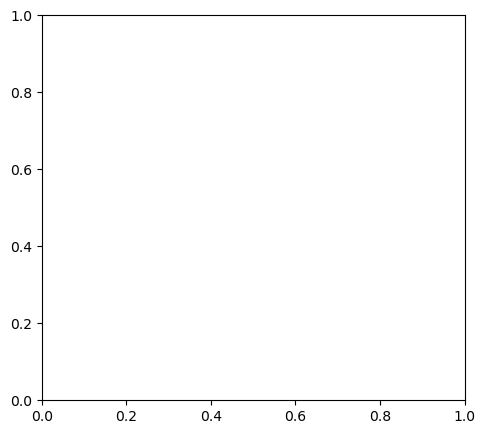

In [40]:


# Visualization
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
train_loss = [x[0] for x in train_losses]
val_loss = [x[0] for x in val_losses]
plt.plot(epochs_range, train_loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
train_acc = [x[0] for x in train_metrics]
val_acc = [x[0] for x in val_metrics]
plt.plot(epochs_range, train_acc, label='Train Acc')
plt.plot(epochs_range, val_acc, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
